In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [3]:
%load_ext autoreload 
%matplotlib inline
%autoreload 2
from utilities import *

# Default figure size
plt.rcParams['figure.figsize'] = (10,5)

* The dataset has been taken from deeplearning.ai [course 2](https://www.coursera.org/learn/deep-neural-network/home/welcome) and is stored in h5py format
* The training and the test set consist of 1080 and 120 samples respectively. Each sample is a colour image of size 64 x 64 pixels
* The classification was implemented using a 3 layer neural network with (64x64x3) 12288 input units, 40 units in the first hidden layer, 20 in the second hidden layer, 6 units representing the six classes in the output layer.  
* The final network wrongly classified only about 10 images from the test set.


In [4]:
# Loading training and test data stored in H5py format
train_dataset = h5py.File('datasets/train_signs.h5','r')
test_dataset = h5py.File('datasets/test_signs.h5','r')

In [5]:
# Separating out the training data and the labels
train_Xorig = np.array(train_dataset['train_set_x'][:])
train_Yorig = np.array(train_dataset['train_set_y'][:])
# the list of classes
classes = np.array(test_dataset["list_classes"][:]) 
print("Training data has shape {0} ".format(train_Xorig.shape))
print ("There are %d images in the training set of size %r pixels"%(train_Xorig.shape[0],train_Xorig.shape[1:3]))
# The last value 3 in train_Xorig.shape indicates RGB values

Training data has shape (1080, 64, 64, 3) 
There are 1080 images in the training set of size (64, 64) pixels


In [6]:
# No of classes
C = classes.size
print("There are %d classes present in the dataset"%C)

There are 6 classes present in the dataset


In [7]:
# Randomizing the order of data in the training set
permute = np.random.permutation(train_Yorig.size)
train_Xorig = train_Xorig[permute]
train_Yorig = train_Yorig[permute]

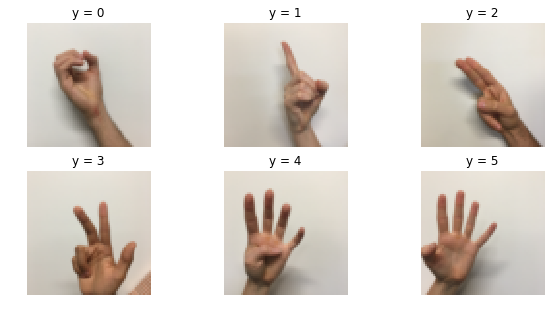

In [8]:
# Vizualizing the data by plotting an example from each class with their labels
val,indices = np.unique(train_Yorig,return_index=True)
for i in range (C):
    img = train_Xorig[indices[i]]
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title('y = ' + str(val[i]))
    plt.axis("off")

plt.show()

In [9]:
# Flattening and Normalizing the images
# Reshaping as (n x m) --> (Features x samples)
X_train = train_Xorig.reshape(train_Xorig.shape[0],-1).T/255
Y_train = train_Yorig
Yhot_train = one_hot_matrix(Y_train,C)
print ("X_train shape: " + str(X_train.shape))
print ("(64,64) pixels has been flatened down to vectors of size %d "% X_train.shape[0])
print ("Yhot_train shape: " + str(Yhot_train.shape)+(" -->\tClasses x Samples"))


X_train shape: (12288, 1080)
(64,64) pixels has been flatened down to vectors of size 12288 
Yhot_train shape: (6, 1080) -->	Classes x Samples


In [10]:
# Performing the same preprocessing on the test set 
test_Xorig = np.array(test_dataset["test_set_x"][:])
test_Yorig = np.array(test_dataset["test_set_y"][:]) 
X_test = test_Xorig.reshape(test_Xorig.shape[0],-1).T/255
Y_test = test_Yorig
print ("The test data consists of %d samples" %X_test.shape[1])
print ("X_test shape: " + str(X_test.shape))

The test data consists of 120 samples
X_test shape: (12288, 120)


In [11]:
# Initialize parameters using HE initialization
def params_initialization(layers,lamb):
    params = {}
    L = len(layers) 
    for l in range(L-1):
        params['W'+str(l+1)] = tf.get_variable('W'+str(l+1),shape=[layers[l+1],layers[l]]
                               ,initializer=tf.keras.initializers.he_normal(seed=l),
                                regularizer =tf.contrib.layers.l2_regularizer(lamb) ) 
        
        params['b'+str(l+1)] = tf.get_variable('b'+str(l+1),shape=[layers[l+1],1]
                               ,initializer = tf.zeros_initializer())
   
    return params
    

In [12]:
# Sanity checking params_initialization
tf.reset_default_graph()
layers = [X_train.shape[0],25,12,C]
params = params_initialization(layers,0.0)
print("W1 = " + str(params["W1"]))
print("b1 = " + str(params["b1"]))
print("W2 = " + str(params["W2"]))
print("b2 = " + str(params["b2"]))
print("W3 = " + str(params["W3"]))
print("b3 = " + str(params["b3"]))

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>


In [13]:
# Forward Propagation
# (L-1) LINEAR -> RELU layers
# Returns the output of the last (L) LINEAR unit
def forward_propagation(X, params):
    A = X
    L = len(params) // 2
    for l in range(1,L):
        A_prev = A
        Z = tf.matmul(params['W'+str(l)],A_prev) + params['b'+str(l)]
        A = tf.nn.relu(Z)
    # Output Layer
    ZL = tf.matmul(params['W'+str(L)],A) + params['b'+str(L)]
    
    return ZL

In [14]:
# Sanity checking forward propagation
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=(X_train.shape),name='X')
with tf.Session() as sess:
    params = params_initialization(layers,0.0)
    ZL = forward_propagation(X,params)
    print ("ZL = "+str(ZL))    

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
ZL = Tensor("add_2:0", shape=(6, 1080), dtype=float32)


In [15]:
# Function to compute the cost (Cross Entropy Loss)
# Takes in the output of the last linear layer from forward_propagation
# Performs the Softmax computation and then calculates the cost
def costFunction(ZL,Y,reg_term):
    
    ZL = tf.transpose(ZL)
    Y = tf.transpose(Y)
    m = tf.to_float(tf.shape(ZL)[0])
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ZL,labels = Y))
    cost = cost + reg_term/m
    
    return cost
    

In [16]:
# Function to implement a Neural Network
def model(X_train,Y_train,layer_dims,alpha =1e-4 ,lamb=0.0,num_epochs = 1000,
          minibatch_size = 64):
    
    ops.reset_default_graph()
    hist_cost = []
    
    
    X = tf.placeholder(tf.float32,shape=(X_train.shape[0],None),name='X')
    Y = tf.placeholder(tf.float32,shape=(Yhot_train.shape[0],None),name='Y')
    
    params = params_initialization(layer_dims,lamb)
    
    regularizer = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_term = tf.reduce_sum(regularizer)
    
    ZL = forward_propagation(X,params)
    
    cost = costFunction(ZL,Y,reg_term)
    num_batches = np.ceil(X_train.shape[1]/minibatch_size)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = alpha).minimize(cost)
    
    init = tf.global_variables_initializer()
        
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0
            minibatches = random_mini_batches(X_train,Yhot_train,minibatch_size)
            for batch in minibatches:
                
                batchX,batchY = batch
                _,batch_cost = sess.run([optimizer,cost],
                                        feed_dict = {X:batchX ,Y:batchY}) 
                epoch_cost += batch_cost/num_batches
            
            hist_cost.append(epoch_cost)
            if epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
               
        
        # Plot the cost
        plt.plot(np.squeeze(hist_cost))
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        #plt.ylim(ymax=50)
        plt.title('Learing Rate = '+ str(alpha))
        plt.show()
        
        parameters = sess.run(params)
        
    return parameters

In [17]:
# 3 layer NN 
# Total number of pixels of each image = 12288 fed as input
# 40 units in the first hidden layer , 20 in the second hidden layer
# No. of classes = 6 units in the output layer

layer_dims = [X_train.shape[0],40,20,C]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Cost after epoch 0: 35.137746
Cost after epoch 100: 1.560259
Cost after epoch 200: 1.077820
Cost after epoch 300: 0.748260
Cost after epoch 400: 0.519467
Cost after epoch 500: 0.353963
Cost after epoch 600: 0.244143
Cost after epoch 700: 0.150519
Cost after epoch 800: 0.093612
Cost after epoch 900: 0.057368
Cost after epoch 1000: 0.031737
Cost after epoch 1100: 0.016307


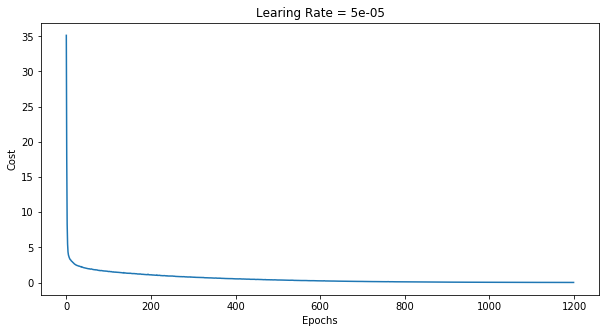

Accuracy on the Training set: 100.0 %
Accuracy on the Test set: 80.83333333333333 %


In [18]:
# Implementing a neural network without regularization
# Plotting the Cost vs Epochs to check for convergence
parameters1 = model(X_train,Yhot_train,layer_dims,alpha=0.00005,
                    num_epochs=1200,lamb = 0.00)

# Calculating the accuracy of the model created
_ = accuracy(X_train,Y_train,X_test,Y_test,parameters1)

Cost after epoch 0: 113.982841
Cost after epoch 100: 59.689970
Cost after epoch 200: 42.748812
Cost after epoch 300: 30.921891
Cost after epoch 400: 22.898619
Cost after epoch 500: 17.119012
Cost after epoch 600: 12.422343
Cost after epoch 700: 8.691892
Cost after epoch 800: 5.814921
Cost after epoch 900: 3.914830
Cost after epoch 1000: 2.705502
Cost after epoch 1100: 1.869414
Cost after epoch 1200: 1.355072
Cost after epoch 1300: 1.000145
Cost after epoch 1400: 0.771218


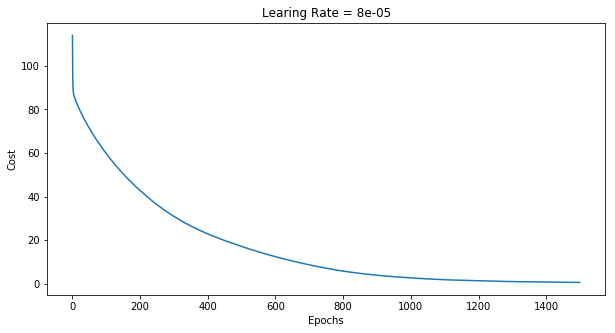

Accuracy on the Training set: 100.0 %
Accuracy on the Test set: 91.66666666666666 %


In [19]:
# Implementing a neural network with regularization
# Plotting the Cost vs Epochs to check for convergence
parameters2 = model(X_train,Yhot_train,layer_dims,alpha=0.00008,
                    num_epochs=1500,lamb = 0.56)

# Calculating the accuracy of the model created and getting the predictions for the test set
pred_ytest = accuracy(X_train,Y_train,X_test,Y_test,parameters2)

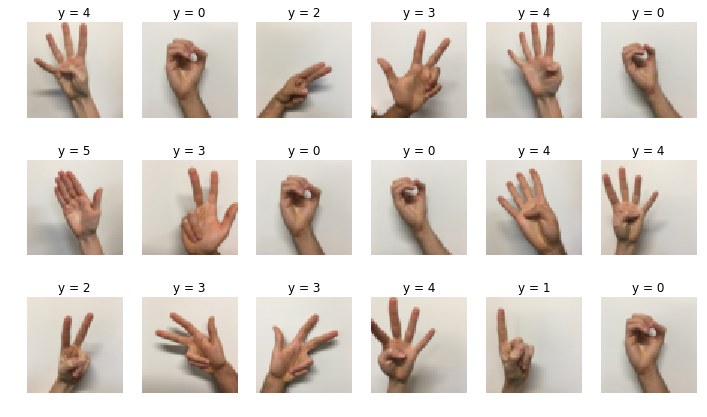

In [20]:
# Plotting 30 random samples from the test set with their predictions

indices = np.random.choice(Y_test.size,20)
plt.figure(figsize=(12,7))

for i in range (18):
    img = test_Xorig[indices[i]]
    plt.subplot(3,6,i+1)
    plt.imshow(img)
    plt.title('y = ' + str(pred_ytest[indices][i]))
    plt.axis("off")

plt.subplots_adjust(hspace = 0.3) 
plt.show()

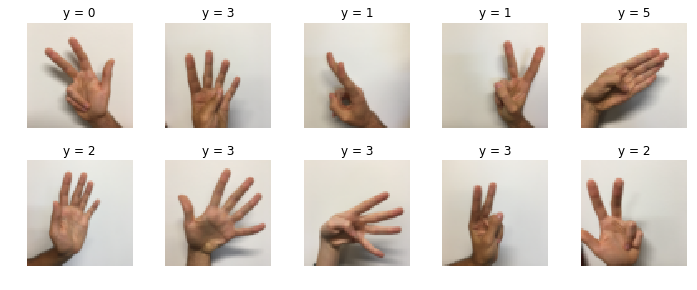

In [21]:
# Plotting samples from the test set which were wrongly classified

plt.figure(figsize=(12,7))
pos = Y_test != pred_ytest
plot_X = test_Xorig[pos]
plot_Y = pred_ytest[pos]

for i in range (plot_X.shape[0]):
    img = plot_X[i]
    plt.subplot(3,5,i+1)
    plt.imshow(img)
    plt.title('y = ' + str(plot_Y[i]))
    plt.axis("off")

plt.subplots_adjust(hspace = 0.3) 
plt.show()
